# 비대칭 데이터 문제 해결
https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html
<img src = 'https://miro.medium.com/max/11405/0*741QMHD5r851Jbvy' width=800 height=500>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
# Imports
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family']='Malgun Gothic'

In [3]:
data = pd.read_pickle('../../pkl/df_filtered-01.pkl')
data.head()

,품목명,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1,서류가공품,판매용,캐나다,1.238,아니오,아니오,아니오,해당없음,N,N,N,0,9.875088,10.088854
2,청주,판매용,일본,3.636,아니오,아니오,아니오,해당없음,N,N,N,0,10.162770,11.453674
3,소스류,판매용,중국,2.004,아니오,아니오,아니오,표시하지않음,N,N,N,0,7.321189,8.016318
4,과실주,판매용,프랑스,5.733,아니오,아니오,아니오,해당없음,N,N,N,0,5.192957,6.939254
5,만두류,판매용,중국,4.540,아니오,아니오,아니오,해당없음,N,N,N,0,7.677864,9.190852


## 1. 데이터 전처리

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

numeric_features = data.drop(['판정결과'], axis=1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.drop(['판정결과'], axis=1).select_dtypes(include=['object', 'category']).columns

X = data.drop('판정결과', axis=1)
y = data['판정결과']

le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [6]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

## 2. 예측

In [7]:
def classification_result(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())])
    
    
    grid_search = RandomizedSearchCV(pipe, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))  
    return grid_search

In [8]:
grid_search_clf = classification_result(refit_score='recall_score')

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     72508
           1       0.37      0.10      0.15       769

    accuracy                           0.99     73277
   macro avg       0.68      0.55      0.57     73277
weighted avg       0.98      0.99      0.99     73277



# 불균형 데이터 처리 방안(imblearn API)
- https://imbalanced-learn.org/stable/

## 1.1. Undersampling(언더 샘플링)
- RandomUnderSampler: random under-sampling method
- TomekLinks: Tomek’s link method
- CondensedNearestNeighbour: condensed nearest neighbour method
- OneSidedSelection: under-sampling based on one-sided selection method
- EditedNearestNeighbours: edited nearest neighbour method
- NeighbourhoodCleaningRule: neighbourhood cleaning rule

In [9]:
from imblearn.under_sampling import *
from imblearn.pipeline import Pipeline, make_pipeline  # scikit-learn의 pipeline을 사용하지 마라!

- <font color = 'blue'> You should import make_pipeline from imblearn.pipeline and not from sklearn.pipeline: make_pipeline from sklearn needs the transformers to implement fit and transform methods but SMOTE does not implement transform.
- 선 교차검증 --> 후 불균형데이터 처리

In [10]:
randomseed = 1024
def classification_result_imbalance(imbalance_method=RandomUnderSampler(random_state=randomseed), refit_score='recall_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('imbalance sampler', imbalance_method),
        ('classifier', RandomForestClassifier())])
    
    smote_pipeline = make_pipeline(preprocessor,
                                   imbalance_method,
                                   RandomForestClassifier())
    
    grid_search = RandomizedSearchCV(smote_pipeline, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))  
    return grid_search

In [11]:
from tqdm import tqdm_notebook

under_sampling_methods = [RandomUnderSampler(random_state=randomseed), TomekLinks(), 
                          OneSidedSelection(), EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
                         ]
# CondensedNearestNeighbour(), NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5)

for mine in tqdm_notebook(under_sampling_methods):
    mine
    grid_search_clf = classification_result_imbalance(imbalance_method=mine, refit_score='recall_score')

RandomUnderSampler(random_state=1024)

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     72508
           1       0.03      0.77      0.06       769

    accuracy                           0.75     73277
   macro avg       0.51      0.76      0.46     73277
weighted avg       0.99      0.75      0.85     73277



TomekLinks()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     72508
           1       0.36      0.10      0.15       769

    accuracy                           0.99     73277
   macro avg       0.68      0.55      0.57     73277
weighted avg       0.98      0.99      0.99     73277



OneSidedSelection()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     72508
           1       0.39      0.10      0.16       769

    accuracy                           0.99     73277
   macro avg       0.69      0.55      0.58     73277
weighted avg       0.98      0.99      0.99     73277



EditedNearestNeighbours(n_neighbors=5)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     72508
           1       0.22      0.18      0.20       769

    accuracy                           0.98     73277
   macro avg       0.60      0.59      0.59     73277
weighted avg       0.98      0.98      0.98     73277



# 1.2. 오버 샘플링
## RandomOverSampler: random sampler
- Random Over Sampling()
- ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning(ADASYN(Adaptive Synthetic Sampling) 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 k개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만드는 방법)
- SMOTE: Synthetic Minority Over-sampling Technique

In [12]:
from imblearn.over_sampling import *

In [15]:
over_sampling_methods = [RandomOverSampler(random_state=randomseed), ADASYN(), SMOTE()]

for mine in tqdm_notebook(over_sampling_methods):
    mine
    grid_search_clf = classification_result_imbalance(imbalance_method=mine, refit_score='recall_score')

  0%|          | 0/3 [00:00<?, ?it/s]

RandomOverSampler(random_state=1024)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     72508
           1       0.19      0.17      0.18       769

    accuracy                           0.98     73277
   macro avg       0.59      0.58      0.58     73277
weighted avg       0.98      0.98      0.98     73277



ADASYN()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     72508
           1       0.12      0.21      0.16       769

    accuracy                           0.98     73277
   macro avg       0.56      0.60      0.57     73277
weighted avg       0.98      0.98      0.98     73277



SMOTE()

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     72508
           1       0.13      0.22      0.16       769

    accuracy                           0.98     73277
   macro avg       0.56      0.60      0.58     73277
weighted avg       0.98      0.98      0.98     73277



# 1.3 복합 샘플링
- SMOTEENN: SMOTE + ENN
            * SMOTE+ENN 방법은 SMOTE(Synthetic Minority Over-sampling Technique) 방법과 ENN(Edited Nearest Neighbours) 방법을 섞은 것이다.
- SMOTETomek: SMOTE + Tomek

In [16]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

hybrid_sampling_methods = [SMOTEENN(random_state=0), SMOTETomek(random_state=4)]

for mine in tqdm_notebook(hybrid_sampling_methods):
    mine
    grid_search_clf = classification_result_imbalance(imbalance_method=mine, refit_score='recall_score')

  0%|          | 0/2 [00:00<?, ?it/s]

SMOTEENN(random_state=0)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     72508
           1       0.08      0.30      0.13       769

    accuracy                           0.96     73277
   macro avg       0.54      0.63      0.56     73277
weighted avg       0.98      0.96      0.97     73277



SMOTETomek(random_state=4)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     72508
           1       0.12      0.23      0.16       769

    accuracy                           0.97     73277
   macro avg       0.56      0.60      0.57     73277
weighted avg       0.98      0.97      0.98     73277



# 1.4.  Ensemble of samplers
## 1.4.1. Classifier including inner balancing samplers
https://imbalanced-learn.org/stable/ensemble.html
### A. Bagging classifier

In [19]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score

In [25]:
def classification_result(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=0)
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', bbc)])
    
    grid_search = RandomizedSearchCV(pipe, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(balanced_accuracy_score(y_test, y_pred))
    
    return grid_search

In [24]:
#bbc.get_params() 사용자함수dml ㄴ
grid_search_clf = classification_result(refit_score='precision_score')

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     72508
           1       0.04      0.63      0.08       769

    accuracy                           0.84     73277
   macro avg       0.52      0.74      0.50     73277
weighted avg       0.99      0.84      0.90     73277

0.7391038165700275


In [21]:
#bbc.get_params()
grid_search_clf = classification_result(refit_score='recall_score')

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     72508
           1       0.04      0.63      0.08       769

    accuracy                           0.84     73277
   macro avg       0.52      0.74      0.50     73277
weighted avg       0.99      0.84      0.90     73277

0.7391038165700275


In BalancedBaggingClassifier, each bootstrap sample will be further resampled to achieve the sampling_strategy desired. Therefore, BalancedBaggingClassifier takes the same parameters than the scikit-learn BaggingClassifier. In addition, the sampling is controlled by the parameter sampler or the two parameters sampling_strategy and replacement, if one wants to use the RandomUnderSampler:

- sampler : 
https://imbalanced-learn.org/stable/auto_examples/ensemble/plot_bagging_classifier.html#sphx-glr-auto-examples-ensemble-plot-bagging-classifier-py
- sampling_strategy :  
https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler

The number of samples in the different classes will be equalized. Possible choices are:
- 'majority': resample only the majority class;
- 'not minority': resample all classes but the minority class; (소수범주 유형의 데이터는 남기고 모든 유형의 데이터를 재표본 추출)
- 'not majority': resample all classes but the majority class; 
- 'all': resample all classes;
- 'auto': equivalent to 'not minority'.

### B. Forest of randomized trees
BalancedRandomForestClassifier is another ensemble method in which each tree of the forest will be provided a balanced bootstrap sample [CLB+04]. This class provides all functionality of the RandomForestClassifier:

In [26]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, average_precision_score, accuracy_score

In [27]:
def classification_result(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', brf)])
    
    grid_search = RandomizedSearchCV(pipe, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f'balanced_accuracy_score: {balanced_accuracy_score(y_test, y_pred)}')
    # AUROC curve
    plot_roc_curve(grid_search, X_test, y_test)  
    plt.show()
    # PR curve
    y_score = grid_search.predict_proba(X_test)[:, 1]
    average_precision = average_precision_score(y_test, y_score)
    disp = plot_precision_recall_curve(grid_search, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision))
    
    return grid_search

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     72508
           1       0.03      0.81      0.06       769

    accuracy                           0.75     73277
   macro avg       0.52      0.78      0.46     73277
weighted avg       0.99      0.75      0.85     73277

balanced_accuracy_score: 0.782863393110723


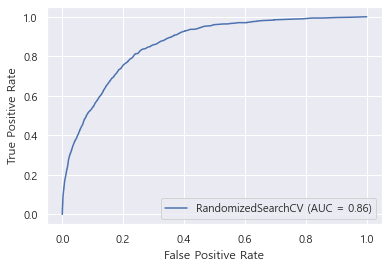

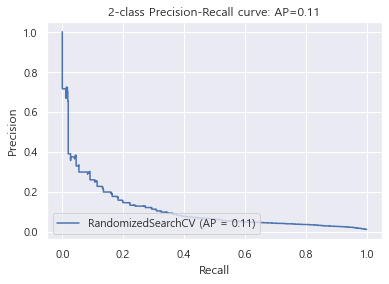

In [28]:
grid_search_clf = classification_result(refit_score='recall_score')

In [58]:
y_true = [0, 1, 0, 0, 1, 0]
y_pred = [0, 1, 0, 1, 1, 1]
accuracy_score(y_true, y_pred)
balanced_accuracy_score(y_true, y_pred)

0.6666666666666666

0.75

### C. Boosting
Several methods taking advantage of boosting have been designed.

RUSBoostClassifier randomly under-sample the dataset before to perform a boosting iteration [SKVHN09]:

In [29]:
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

In [30]:
def classification_result(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0) 
    # EasyEnsembleClassifier(random_state=0)
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', rusboost)])
    
    grid_search = RandomizedSearchCV(pipe, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(balanced_accuracy_score(y_test, y_pred))
    
    return grid_search

In [31]:
grid_search_clf = classification_result(refit_score='recall_score')

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     72508
           1       0.02      0.23      0.04       769

    accuracy                           0.89     73277
   macro avg       0.51      0.56      0.49     73277
weighted avg       0.98      0.89      0.93     73277

0.5633789622460744


A specific method which uses AdaBoostClassifier as learners in the bagging classifier is called “EasyEnsemble”. The EasyEnsembleClassifier allows to bag AdaBoost learners which are trained on balanced bootstrap samples [LWZ08]. Similarly to the BalancedBaggingClassifier API, one can construct the ensemble as:

# End